<b> COURSEWORK 3 <b>

In [131]:
import sys, os, time
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import networkx as nx
import math
from scipy.misc import derivative
from numpy import diff

# %% Load dataset

datadir = 'data/dataset3_m62/'
trackdata = io.loadmat(datadir+'downTrackdata.mat')
phi = trackdata['phi']; x = trackdata['x']; y = trackdata['y']; r=trackdata['r'];
speed = trackdata['speed']; t = trackdata['time'];
spikedata = io.loadmat(datadir+'spikes.mat')
spikes = spikedata['spikes']
params = spikedata['params']
fluodata = io.loadmat(datadir+'fissa_output.mat')
dFonF = fluodata['ddf_f'] # fluorescence time-series variable
C = np.size(dFonF,0) # number of cells
fs = 30.92 # sampling rate in Hz - everything is resampled at this rate
L = np.size(dFonF,1)
t = np.linspace(0,L*1/fs,L) # duration of recording in sec

In [132]:
# %% Center all figures 

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;}
</style>
""")

In [133]:
# %%Usefull datasets

#data of all cells 
cell= dFonF

#extract data of the first cell 
cell_1 = dFonF[0]

#extract data of the second cell 
cell_2 = dFonF[1]

#extract data of the third cell 
cell_3 = dFonF[2]

<b>QUESTION 1<b> 

-- Write a function to convert each time series into an event train where an event corresponds to the beginning of a detected calcium transient --

In [134]:
# %% Create a function to detect event train

def event_train(cell):
    events = np.zeros(len(cell)) #initialise events as an array
    detection_point = [] 
    dx=0.1  #using the time step of 0.1  
    dx_cell = diff(cell)/dx  #calculate the derivative of the cell 
    dx_cell = np.append(dx_cell,[0]) #set the derivative length to have the same as the calcium transient data
    threshold = 7.5 #look at the derivative and set a threshold where only significant events/values are taken
    for i in range(len(dx_cell)):
        if dx_cell[i] >= threshold: #set the condition to find the data points above the threshold
            events[i] = 1 #set the value of 1 for events following the condition above 
    return events

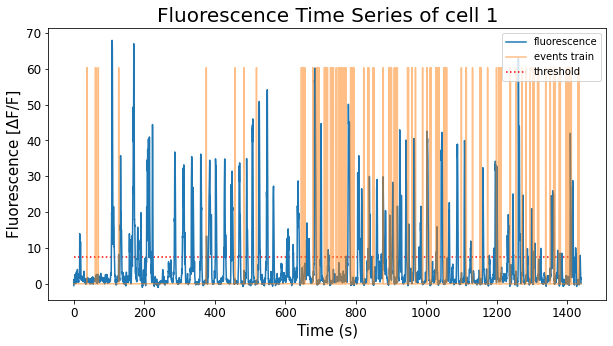

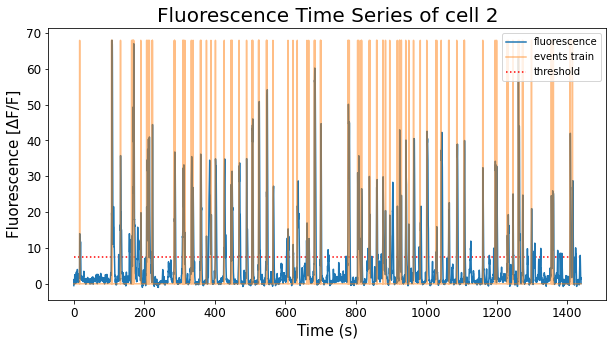

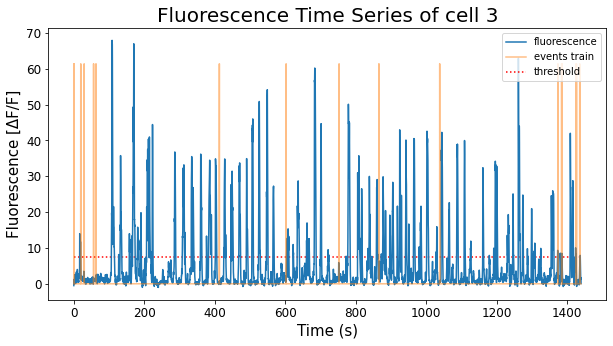

In [135]:
# %% Plot event trains of cell 1

#draw the fluorescence time series of cell 1 with the events train detected above 
plt.figure(figsize=(10,5))
plt.plot(t,cell_2, label='fluorescence')
plt.plot(t,event_train(cell_1)*np.max(cell_1), alpha=0.5, label='events train')
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Fluorescence [ΔF/F]', fontsize = 15)
plt.title('Fluorescence Time Series of cell 1', fontsize = 20)

# draw the threshold of 7.5 specified above 
line = plt.hlines(7.5,0,1440, colors='r', linestyles=':', label='threshold')
plt.tick_params(axis= 'both' , labelsize= 12)
plt.legend(loc="upper right")

# %% Plot event trains of cell 2

#draw the fluorescence time series of cell 2 with the events train detected above 
plt.figure(figsize=(10,5))
plt.plot(t,cell_2, label='fluorescence')
plt.plot(t,event_train(cell_2)*np.max(cell_2), alpha=0.5, label='events train')
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Fluorescence [ΔF/F]', fontsize = 15)
plt.title('Fluorescence Time Series of cell 2', fontsize = 20)

# draw the threshold of 7.5 specified above 
line = plt.hlines(7.5,0,1440, colors='r', linestyles=':', label='threshold')
plt.tick_params(axis= 'both' , labelsize= 12)
plt.legend(loc="upper right")

# %% Plot event trains of cell 3

#draw the fluorescence time series of cell 3 with the events train detected above 
plt.figure(figsize=(10,5))
plt.plot(t,cell_2, label='fluorescence')
plt.plot(t,event_train(cell_3)*np.max(cell_3), alpha=0.5, label='events train')
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Fluorescence [ΔF/F]', fontsize = 15)
plt.title('Fluorescence Time Series of cell 3', fontsize = 20)

# draw the threshold of 7.5 specified above 
line = plt.hlines(7.5,0,1440, colors='r', linestyles=':', label='threshold')
plt.tick_params(axis= 'both' , labelsize= 12)
plt.legend(loc="upper right")

<b>QUESTION 2<b>

-- Write a function that returns the data for a cell in the form response[trial,position] and plot rastergrams that show high, medium and low selectorivity of the cell's firing

In [136]:
# %% Create a function to break up the fluorescence response of each cell into laps

#inputs of the functions are the following:
#sp: a vector of a cell's activity binarized into 0,1 (spiking/not-spiking)
#phi_bin: sequence of angular position values, binned into nphi_bins
#nlaps: number of trials
#nphi: number of angle

def get_lapresponse(sp,phi_bin,nlaps,nphi): 
    r = np.zeros((nlaps,nphi))
    lap=0
    phi0=phi_bin[0]
    lapflag=True  # flag to ensure we only increment lap counter on first time in bin
    for i in range(0,L):
        if  sp[i]:
            r[lap][phi_bin[i]-1] += 1
        # and augment lap counter
        if (phi_bin[i]==phi0 and lapflag==True):
            lap += 1
            lapflag=False # put down flag until we are past this bin
            #print(lap)
        if phi_bin[i]>phi0:
            lapflag=True

    return r

# %% bin the spatial variable phi
nbins_phi = 20    #create 20 bins for the spatial angles 
edges = np.arange(0,360,360/nbins_phi)    #sequence of angles from 0 to 360
phi_bin = np.digitize(phi,edges)    #gives indices of the bins to which each value in input array belongs

# %% compute how many laps does the mouse do
# use big jumps in position to mark clocking around circular path
dphi = np.diff(phi_bin,axis=0)
nlaps = np.count_nonzero(dphi>10)+2    #a bit of a hack, sorry - but this works


In [137]:
# %% Create a function to get the events position occuring in cells 

def get_response(Response):   #get response[trial,position]
    events = np.zeros((len(Response),len(Response[0])))    #initialise a matrix of zeros  
    zero_val = 0   #initialise a value where below it, there won't be an event 
    for i in range(len(Response)):
        for j in range (len(Response[0])):
            if Response[i][j] <= zero_val:    #condition: if the value is below zero - no event 
                events [i][j] = -10    #chose -10 so that no spike appears 
            else: 
                events [i][j] = (j+1)*18   #outputs the corresponding angle 
    return events

In [138]:
# %%Compute the binary value of the events for the cells and the corresponding response (0 or 1)

#for cell 1: 
binary_val1 = event_train(cell_1)   #use function above to compute the binary value of the events in cell 1
Response1 = get_lapresponse(binary_val1,phi_bin,nlaps,20)   #get the binary response of cell 1

# for cell2:
binary_val2 = event_train(cell_2)   #use function above to compute the binary value of the events in cell 2
Response2 = get_lapresponse(binary_val2,phi_bin,nlaps,20)   #get the binary response of cell 2

#for cell 3:
binary_val3 = event_train(cell_3)   #use function above to compute the binary value of the events in cell 3
Response3 = get_lapresponse(binary_val3,phi_bin,nlaps,20)   #get the binary response of cell 3

Number of spikes in cell 1: 1090.0


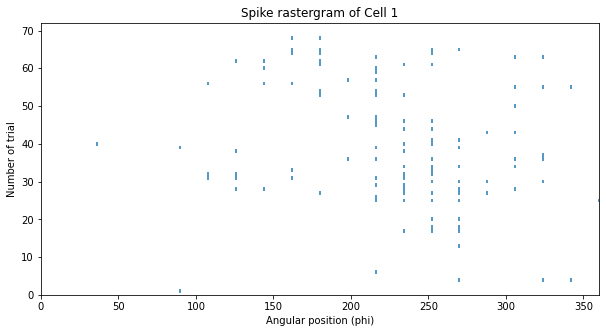

Number of spikes in cell 2: 1024.0


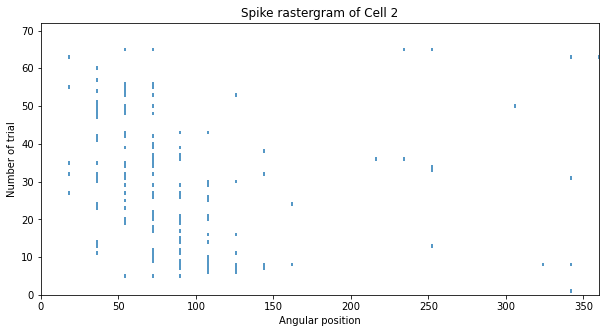

Number of spikes in cell 3: 206.0


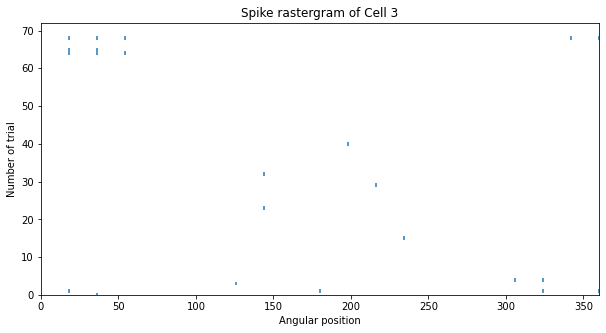

In [139]:
# %%Plot the rastergrams of the three cells

#for cell 1:
raster1 = get_response(Response1)   
plt.figure(figsize=(10,5))
plt.eventplot(raster1, linelengths = 1)  #draw the spike rastergram  
plt.title('Spike rastergram of Cell 1')
plt.xlabel('Angular position (phi)')
plt.xlim(0,360) 
plt.ylabel('Number of trial')
plt.ylim(0,72)
#compute number of spikes in cell 1
numb_spikes1 = sum(binary_val1)
print('Number of spikes in cell 1:',numb_spikes1)
plt.show()
 
    
#for cell 2:
raster2 = get_response(Response2)
plt.figure(figsize=(10,5))
plt.eventplot(raster2, linelengths = 1)    #draw the spike rastergram  
plt.title('Spike rastergram of Cell 2')
plt.xlabel('Angular position')
plt.xlim(0,360)
plt.ylabel('Number of trial')
plt.ylim(0,72)
numb_spikes2 = sum(binary_val2)
print('Number of spikes in cell 2:',numb_spikes2)
# Display the spike raster plot
plt.show()


#for cell 3:
raster3 = get_response(Response3)
plt.figure(figsize=(10,5))
plt.eventplot(raster3, linelengths = 1)     
plt.title('Spike rastergram of Cell 3')
plt.xlabel('Angular position')
plt.xlim(0,360)
plt.ylabel('Number of trial')
plt.ylim(0,72)
#compute number of spikes in cell 3
numb_spikes3 = sum(binary_val3)
print('Number of spikes in cell 3:',numb_spikes3)
plt.show()

<b>QUESTION 3<b>

-- Calculate the mutual information between the binary response variable and the spatial angle phi

In [140]:
# %%Use the shannon entropy as the plugin estimator for mutual information
def shannon_entropy(px):
    idx=px>0 
    H= -np.sum(px[idx]*np.log2(px[idx]))
    return H

#At a conceptual level, Shannon's Entropy is simply the "amount of information" in a variable. 
#More mundanely, that translates to the amount of storage (e.g. number of bits) required to store the variable
#, which can intuitively be understood to correspond to the amount of information in that variable.


# %%Create a function to estimate a mutual information

def mutual_info(X, Y, nbins_phi):   #X and Y random variable 
    Cx, _ =np.histogram(X, nbins_phi)
    Cy, _ =np.histogram(Y, nbins_phi)
    Cxy, _, _ = np.histogram2d(X, Y, nbins_phi)
    #Normalise to give a probability distribution 
    Px = Cx / Cx.sum()
    Py = Cy / Cy.sum()
    Pxy = Cxy / Cxy.sum()
    #estimate the probabilities for all the binned angles and binary responses
    Hx = shannon_entropy(Px)  #estimate P(angle) 
    Hy = shannon_entropy(Py)  #estimate P(response)
    Hxy = shannon_entropy(Pxy)  #estimate P(response|angle)
    
    I = Hx + Hy - Hxy   
    return I 

In [141]:
# %%Compute mutual information for the first three cells

numb_cells=138 #numb of cells in dFonF 
MI=np.zeros(numb_cells) #initialise mutual information
cell_idx=[0,1,2]  #indices for cell1, cell2 and cell3

for i in range(numb_cells):
    cell = dFonF[i] 
    angl= edges[phi_bin-1].reshape(44520)
    Im = mutual_info(angl, event_train(cell), nbins_phi)
    MI[i] = Im     #calculate the mutual information of the corresponding cell
    if i in cell_idx :
        print("For cell", cell_idx[i]+1,": mutual information =", MI[i], "bits") 

For cell 1 : mutual information = 0.01794349900521741 bits
For cell 2 : mutual information = 0.02593581047053828 bits
For cell 3 : mutual information = 0.003582819648946689 bits


In [142]:
# %%Double check our results using SKLearn

from sklearn.metrics import mutual_info_score

for i in cell_idx:
    cell = dFonF[i]
    Cxy, _, _ = np.histogram2d(angl, event_train(cell), nbins_phi)
    MI_ = mutual_info_score(None, None, contingency=Cxy)
    print("For cell", cell_idx[i]+1,": mutual information =", MI_, "bits")

For cell 1 : mutual information = 0.012437485744846507 bits
For cell 2 : mutual information = 0.017977333903190406 bits
For cell 3 : mutual information = 0.0024834213381216084 bits


<b>QUESTION 4<b>

-- Calculate the estimates' bias and comment on it 

In [143]:
# %% Create a function that computes the estimations' bias 

def MI_bias(resp):
    N = resp.shape[0]*resp.shape[1]  #total number of samples - number of trials*number of bins
    R = 2   #number of possible responses over all the stimulus - spike (=1) or no spike (=0)
    R_s = np.zeros(Response1.shape[0])   #number of possible responses for each stimuli (s)
    R_s_max = np.full(Response1.shape[0], 2)  
    for s in range(len(R_s)):   
        if 1 in resp[s,:] and 0 in resp[s,:]:
            R_s[s] = 2   
        else:
            R_s[s] = 1       
    low_bias = -1/(2*N*np.log(2))*(R-1-np.sum(R_s-1))     #bias due to underestimation
    high_bias = -1/(2*N*np.log(2))*(R-1-np.sum(R_s_max-1))   #bias due to overestimation 
    
    return low_bias, high_bias  
    
#compute the bias for the first three cells 
bias_cell1 = MI_bias(Response1)
bias_cell2 = MI_bias(Response2)
bias_cell3 = MI_bias(Response3)

print('Bias range of cell 1: ', bias_cell1)
print('Bias range of cell 2: ', bias_cell2)
print('Bias range of cell 3: ', bias_cell3)


Bias range of cell 1:  (0.0025399560579031045, 0.03555938481064346)
Bias range of cell 2:  (0.0060958945389674515, 0.03555938481064346)
Bias range of cell 3:  (0.0005079912115806209, 0.03555938481064346)


<b>QUESTION 5<b>

-- Calculate the spatial information rates for all cells and plot the distribution

The cell number 2 has the highest spatial mutual information rate with IR = 0.025575590880669692


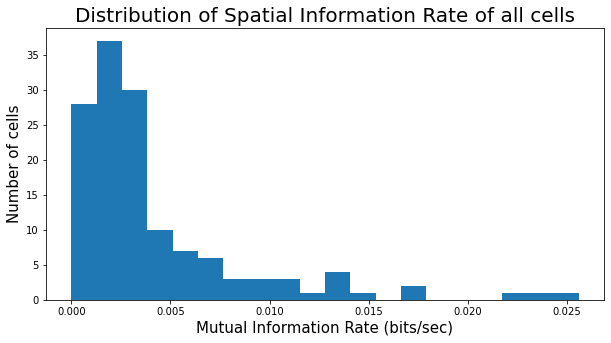

In [144]:
# %% Useful calculations

avg_lap_rate= nlaps/1440   #calculate the average number of laps per seconds the mouse does 
avg_lap_time= 1/avg_lap_rate #calculate the average number of seconds the mouse takes to turn around in circles 
bin_width = avg_lap_time/nbins_phi #calculate the time from one bin to another 

# %% Calculate the spatial information rate for all the cells 
info_rate = np.zeros(numb_cells)  
for i in range(numb_cells):
   # Spatial Mutual Information rate = Shannon mutual information (bits)/response bin width (sec)
   info_rate[i] = MI[i] / bin_width #number of bits per second

# %% Find the cell with the highest spatial mutual information rate
max_info_rate_i = np.argmax(info_rate)
max_info_rate = info_rate[max_info_rate_i] 
print("The cell number",max_info_rate_i+1,"has the highest spatial mutual information rate with IR =",max_info_rate)

# %%Plot the distribution of the spatial information rate  
plt.figure(figsize=(10,5))
plt.hist(info_rate, bins=nbins_phi)
plt.title('Distribution of Spatial Information Rate of all cells',fontsize=20)
plt.xlabel("Mutual Information Rate (bits/sec)", fontsize=15)
plt.ylabel("Number of cells",fontsize=15)
plt.show()

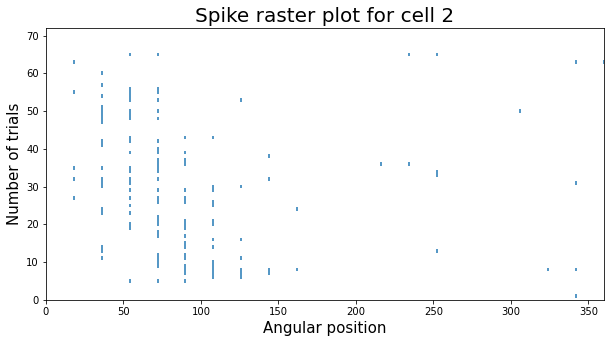

In [145]:
# %% Plot the response for cell 2 (cell with higher information rate)
plt.figure(figsize=(10,5))
plt.eventplot(raster2, linelengths = 1)     
plt.title('Spike raster plot for cell 2', fontsize=20)
plt.xlabel('Angular position', fontsize=15)
plt.xlim(0,360)
plt.ylabel('Number of trials', fontsize=15)
plt.ylim(0,72)
plt.show()